In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def image_show(img,titles):
    plt.title(titles)
    
    plt.imshow(img)
    plt.show()

In [3]:
print("testing")

testing


In [4]:
def get_dark_channel(img, patch_size = 20):
    min_channel = np.min(img, axis = 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dc_channel = cv2.erode(min_channel, kernel)
    return dc_channel
    


In [5]:
def alight(img, dc_channel, top_percent = 0.1):
    h, w = dc_channel.shape
    num_pixels = int(max(h*w*top_percent, 1))
    dark_vec = dc_channel.reshape(-1)
    img_vec = img.reshape(-1,3)
    indices = np.argsort(-dark_vec)
    top_indices = indices[:num_pixels]
    brightest = img_vec[top_indices]
    a = np.max(brightest, axis = 0)
    return a;

In [6]:
def t_map(img, a, omega = 0.95, patch_size = 20):
    normised = img.astype(np.float64)/a.reshape(1,1,3)
    normised = (normised*255).astype(np.uint8)
    dc_channel = get_dark_channel(normised, patch_size)
    t = 1 - omega*(dc_channel.astype(np.float64)/255)
    return t
    

In [7]:
def image_recover(I, t, A=(0.95, 0.95, 0.95), t_min=0.1):
    t = np.clip(t, t_min, 1.0)[:, :, np.newaxis]
    A = np.array(A)
    J = (I - A) / t + A
    return np.clip(J, 0, 1)

In [8]:
import os
import h5py
import numpy as np
import cv2

def load_image_and_trans(hazy_path, trans_path):
    img = cv2.imread(hazy_path)
    if img is None:
        raise FileNotFoundError(f"Could not read hazy image: {hazy_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    
    _, ext = os.path.splitext(trans_path)
    
    if ext.lower() == '.png':
        # Load transmission PNG
        trans_img = cv2.imread(trans_path)
        if trans_img is None:
            raise FileNotFoundError(f"Could not read transmission PNG: {trans_path}")
        
        # Convert to grayscale
        trans = cv2.cvtColor(trans_img, cv2.COLOR_BGR2GRAY).astype(np.float32)
        
        # Normalize like .mat: clip & divide by 99th percentile
        p99 = np.percentile(trans, 99)
        trans = np.clip(trans, 0, p99)
        trans = trans / p99
        
        print("✅ Loaded image & PNG transmission map")
        print(f"   Image shape: {img.shape}")
        print(f"   Transmission map shape: {trans.shape}")
        return img, trans
    
    else:
        # Load from .mat
        with h5py.File(trans_path, 'r') as f:
            keys = list(f.keys())
            if not keys:
                raise ValueError(f"No datasets found in {trans_path}")
            key = keys[0]
            trans = np.array(f[key][:]).T
        
        trans = trans.astype(np.float32)
        trans = np.clip(trans, 0, np.percentile(trans, 99))
        trans = trans / np.percentile(trans, 99)
        
        print("✅ Loaded image & .mat transmission map")
        print(f"   Image shape: {img.shape}")
        print(f"   Transmission map shape: {trans.shape}")
        return img, trans


In [9]:
img_path = "/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg"
trans_path = "/kaggle/input/transdata/depth/depth/depth/0138.mat"
img, trans_actual = load_image_and_trans(img_path,trans_path) 

✅ Loaded image & .mat transmission map
   Image shape: (413, 550, 3)
   Transmission map shape: (413, 550)


In [10]:
dc_channel = get_dark_channel(img, 20)
a = alight(img, dc_channel)
t_predict = t_map(img, a)

In [11]:
t_predict.shape

(413, 550)

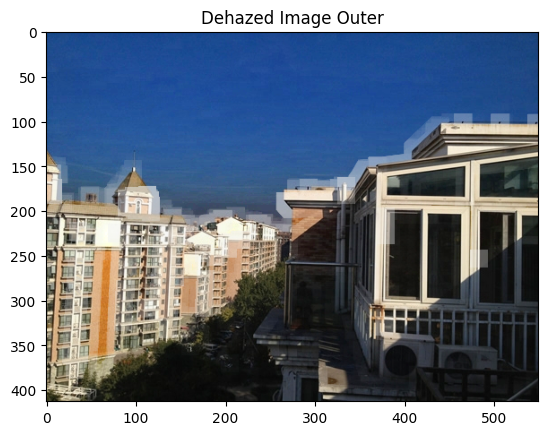

In [12]:
dehazed = image_recover(img, t_predict)
image_show(dehazed, 'Dehazed Image Outer')

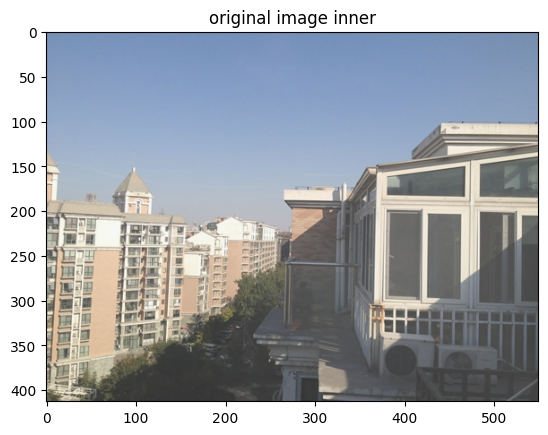

In [13]:
image_show(img, "original image inner")

In [14]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import numpy as np

def compute_ssim_mse(hazy_patch, dehazed_patch):

    if hazy_patch.dtype == np.uint8:
        hazy_patch_norm = hazy_patch.astype(np.float32) / 255.0
    else:
        hazy_patch_norm = hazy_patch.astype(np.float32)

    if dehazed_patch.dtype == np.uint8:
        dehazed_norm = dehazed_patch.astype(np.float32) / 255.0
    else:
        dehazed_norm = dehazed_patch.astype(np.float32)
    
    height, width = hazy_patch_norm.shape[:2]
    min_dim = min(height, width)
    win_size = min_dim if min_dim % 2 == 1 else min_dim - 1
    win_size = max(7, win_size) 
    
    ssim_value = ssim(
        hazy_patch_norm,
        dehazed_norm,
        win_size=win_size,
        channel_axis=-1,
        data_range=1.0
    )
    
    # Compute MSE
    mse_value = mean_squared_error(hazy_patch_norm, dehazed_norm)
    
    return ssim_value, mse_value


In [15]:
# Example: call the function
ssim_val, mse_val = compute_ssim_mse(img, dehazed)

print(f"SSIM: {ssim_val:.4f}")
print(f"MSE: {mse_val:.6f}")


SSIM: 0.7663
MSE: 0.059988


In [ ]:
def compute_psnr_single(hazy_patch, y_true_flat, y_pred_flat):
    if hazy_patch.dtype != np.uint8:
        hazy_patch_uint8 = np.clip(hazy_patch * 255, 0, 255).astype(np.uint8)
    else:
        hazy_patch_uint8 = hazy_patch
    g_img = cv2.cvtColor(hazy_patch_uint8, cv2.COLOR_RGB2GRAY)
    
    avg_intensity = np.mean(g_img)
    mse_val = mean_squared_error(y_true_flat, y_pred_flat)
    mse_val = max(mse_val, 1e-10)
    psnr = 20 * math.log10(avg_intensity / (mse_val ** 0.5))
    return psnr


In [ ]:
y_test_flat = np.ravel(trans_actual)
y_pred_flat = np.ravel(t_predict)

In [ ]:
import math

In [ ]:
psnr = compute_psnr_single(img, y_test_flat,y_pred_flat )
print("psnr:-", psnr)

**for inner image**

In [113]:
img_new_inner = "/kaggle/input/indoor-training-set-its-residestandard/hazy/1031_10_0.75372.png"
trans_new_inner = "/kaggle/input/indoor-training-set-its-residestandard/trans/1031_10.png"


✅ Loaded image & PNG transmission map
   Image shape: (460, 620, 3)
   Transmission map shape: (460, 620)


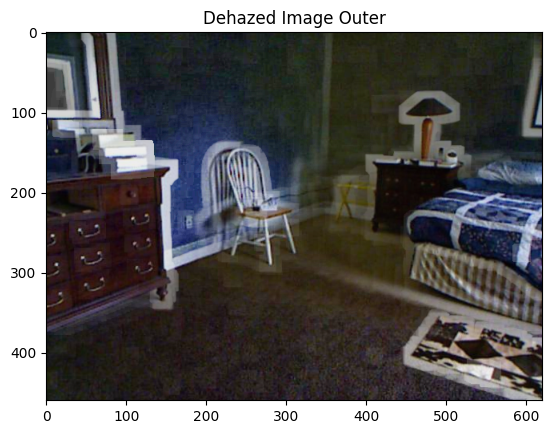

In [114]:
img_inner,trans_actual_inner = load_image_and_trans(img_new_inner,trans_new_inner) 

dc_channel = get_dark_channel(img_inner, 20)
a = alight(img_inner, dc_channel)
t_predict_inner = t_map(img_inner, a)
dehazed_inner = image_recover(img_inner, t_predict_inner)
image_show(dehazed_inner, 'Dehazed Image Outer')

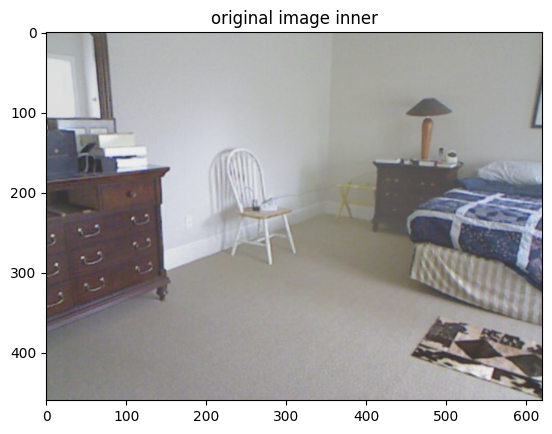

In [115]:
image_show(img_inner, "original image inner")

In [116]:
ssim_val_inner, mse_val_inner = compute_ssim_mse(img_inner, dehazed_inner)

print(f"SSIM: {ssim_val_inner:.4f}")
print(f"MSE: {mse_val_inner:.6f}")

SSIM: 0.2721
MSE: 0.163196


In [117]:
trans_actual_inner = load_and_normalize_png_transmission(trans_new_inner)

   Original shape: (460, 620, 3)
   Final shape: (460, 620), dtype: float32


In [118]:
t_predict_inner.shape

(460, 620)

In [119]:
y_test_flat_inner = np.ravel(trans_actual_inner)
y_pred_flat_inner = np.ravel(t_predict_inner)

In [120]:
psnr = compute_psnr_single(img_inner, y_test_flat_inner,y_pred_flat_inner )
print("psnr:-", psnr)

psnr:- 51.885075348465676
